## Soleil DiffAbs XRD:
* [Calibration](#calibration)
* [Dark](#dark)
* [Flat](#flat)
* [Mask](#mask)
* [Integration](#integration)

TODO
- faire un mask, dark, flat correct. (voir avec SIXS).
- corriger du moniteur. (I0)

## Calibration ImXPadS140  <a name="calibration"></a>

This tutorial is for the calibration of an Xpad_s140 on the Soleil DiffAbs Diffractometer.

The calibration data is a scan on the delta motor with a CeO2 calibrant.

In [1]:
%matplotlib notebook

# first the imports
from typing import Iterator, List, NamedTuple, Optional, Text, Tuple

import os
import functools
import time

from collections import namedtuple
from math import pi

import numpy
import pylab
import pyFAI
import scipy.stats

import ipywidgets as widgets

from h5py import Dataset, File
from IPython.display import display
from numpy import ndarray
from pyFAI.detectors import detector_factory
from pyFAI.gui import jupyter

# local import
from soleil import Angle, Calibrant, Calibration, CalibrationFunctions, CalibrationFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    DatasetPath, DatasetPathContains, DatasetPathWithAttribute, get_dataset,\
    calibration, integrate, save_as_edf

In [2]:
# temporary until the ruch is ON
ROOT = os.path.join("/nfs", "ruche-diffabs", "diffabs-users", "20170882", "2018", "Run2")
PUBLISHED = os.path.join("/nfs", "ruche-diffabs", "diffabs-users", "20170882", "published-data")

COM_DIFFABS = os.path.join("/nfs", "ruche-diffabs", "diffabs-soleil", "com-diffabs")

# Flat
ROOT_FLAT = os.path.join("/nfs", "ruche-diffabs", "diffabs-users", "20170063")

# Dark
ROOT_DARK = COM_DIFFABS


In [3]:
# do a calibration with a well centered sample.

# TODO recuperer le point de départ à partir des ponis de référence.
# TODO ajouter le diagramme complet à la fin.

json = os.path.join(PUBLISHED, "xrd", "calibration", "calibration.json")

distance = Length(0.644)
poni1 = Length(0.015639111692746385)
poni2 = Length(0.026262764736101073)
rot1_scale = -1
rot1_offset = Angle(-15.999503651711137)
rot2 = Angle(0)
rot3 = Angle(0)

functions = (
    CalibrationFunctions("dist", "poni1", "poni2",
                         "pi * (rot1_scale * delta + rot1_offset) / 180",
                         "rot2",
                         "rot3"),
    [Parameter[Length]("dist", distance, (distance-0.05, distance+0.05)),
     Parameter[Length]("poni1", poni1, (poni1-0.01, poni1+0.01)),
     Parameter[Length]("poni2", poni2, (poni2-0.01, poni2+0.01)),
     Parameter[float]("rot1_scale", rot1_scale, (rot1_scale-0.1, rot1_scale+0.1)),
     Parameter[Angle]("rot1_offset", rot1_offset, (rot1_offset-1, rot1_offset+1)),
     Parameter[float]("rot2", rot2, (rot2-0.1, rot2+0.1)),
     Parameter[Angle]("rot3", rot3, (rot3, rot3))]
)

# conserve the image available for calibration, remove others
def to_use(frame: CalibrationFrame) -> bool:
   
    return True if frame.idx in range(0,30) else False

params = Calibration(os.path.join(PUBLISHED, "xrd", "calibration"),
                     os.path.join(ROOT, "2018-04-03", "XRD_22.nxs"),
                     DatasetPathWithAttribute("interpretation", b"image"),
                     DatasetPathContains("scan_data/actuator_1_1"),
                     [3,4,5,6,7,8,9],
                     to_use,
                     Calibrant("CeO2"),
                     Detector("imxpads140"),
                     Wavelength(6.8877e-11),
                     functions
                    )

In [4]:
from functools import partial

def on_click_button(cmd, b):
    ! {cmd}
    
def my_cmd_button(cmd, description):
    # Click the button to open the data with silx
    button = widgets.Button(
        description=description,
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click me',
        icon='check',
        layout = widgets.Layout(width='auto')
    )

    display(button)

    button.on_click(partial(on_click_button, cmd))

    return button

In [5]:
silx = my_cmd_button("silx view --use-opengl-plot " + params.filename,
                     'Silx View ' + os.path.basename(params.filename))

In [6]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].
# temporary until pyFAI-calib2 can read from NeXuS files.

cmds = save_as_edf(params)
for cmd, idx in zip(cmds, params.idxs):
    my_cmd_button(cmd, 'PyFAI-calib2 ' + os.path.basename(params.filename) + " " + str(idx))

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .
Detector Imxpad S140	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.887700e-11m
SampleDetDist= 5.902559e-01m	PONI= -3.482004e-02, 1.811442e-01m	rot1=0.071829  rot2= 0.078934  rot3= 0.000000 rad
DirectBeamDist= 593.630mm	Center: x=1066.719, y=92.223 pix	Tilt=6.112 deg  tiltPlanRotation= 132.218 deg
Detector Imxpad S140	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.887700e-11m
SampleDetDist= 6.271364e-01m	PONI= 2.769683e-02, 1.542786e-01m	rot1=-0.009310  rot2= -0.018944  rot3= 0.000000 rad
DirectBeamDist= 627.276mm	Center: x=1231.674, y=121.648 pix	Tilt=1.209 deg  tiltPlanRotation= -63.831 deg
Detector Imxpad S140	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.887700e-11m
SampleDetDist= 5.737896e-01m	PONI= -2.147601e-01, 1.409221e-01m	rot1=-0.056358  rot2= 0.364272  rot3= 0.000000 rad
DirectBeamDist= 615.060mm	Center: x=1333.033, y=33.592 pix	Tilt=21.109 deg  tiltPlanRotation= 81.596 deg
Detector Imxpad S14

<IPython.core.display.Javascript object>


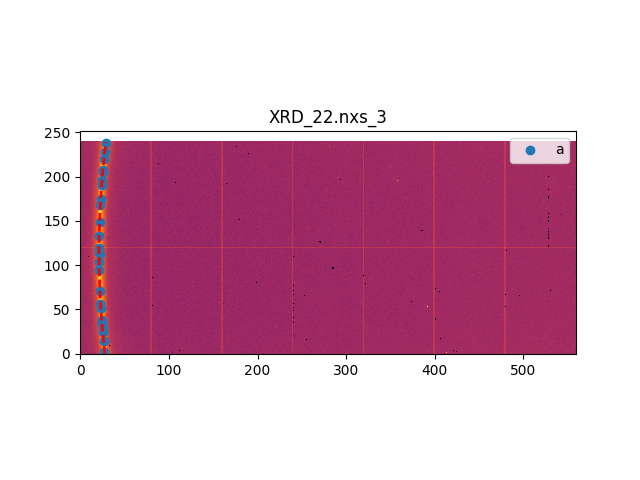

<IPython.core.display.Javascript object>


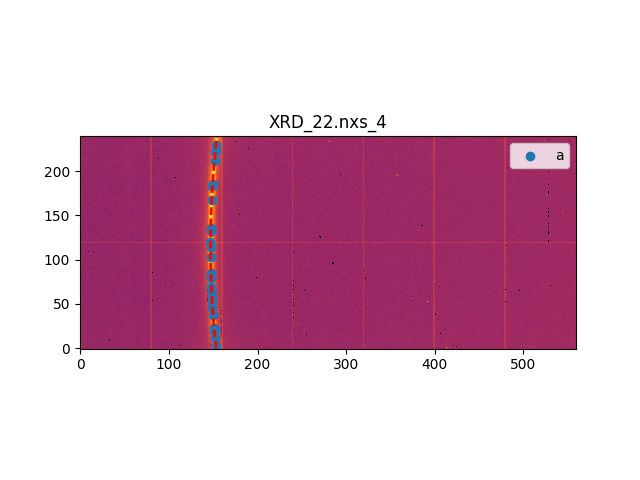

<IPython.core.display.Javascript object>


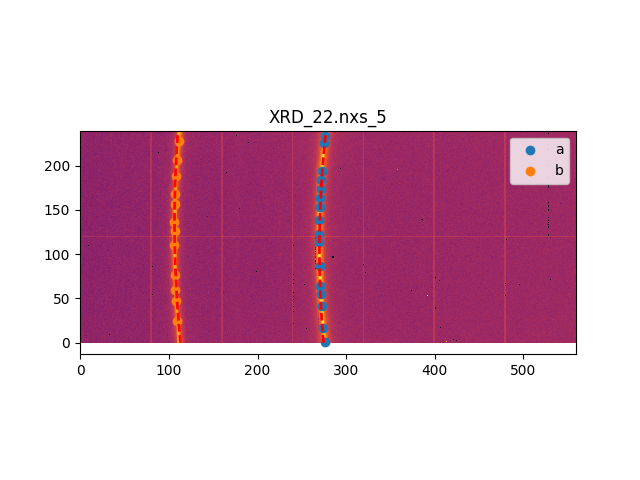

<IPython.core.display.Javascript object>


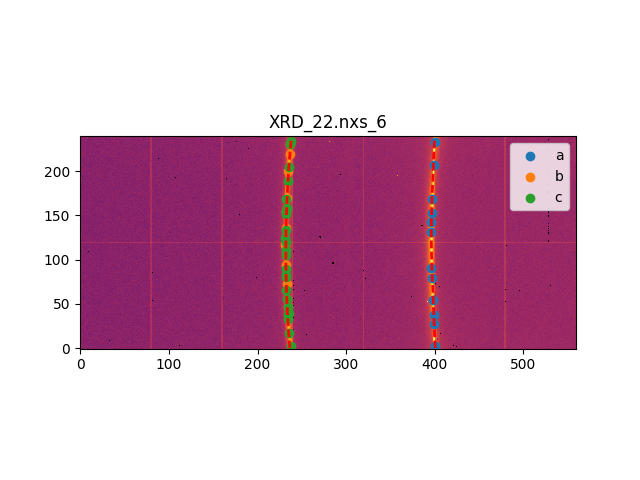

<IPython.core.display.Javascript object>


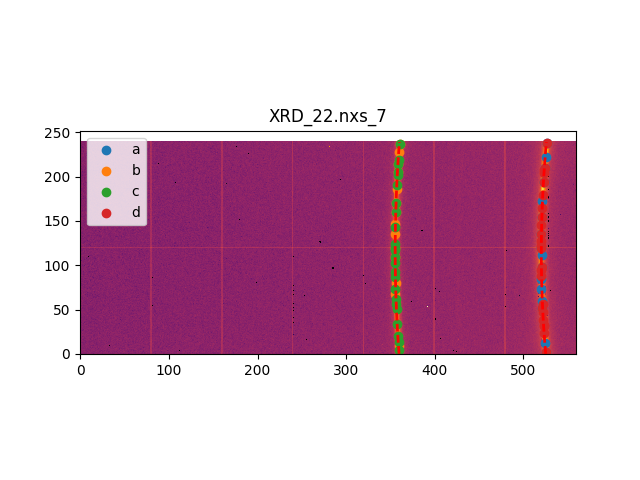

<IPython.core.display.Javascript object>


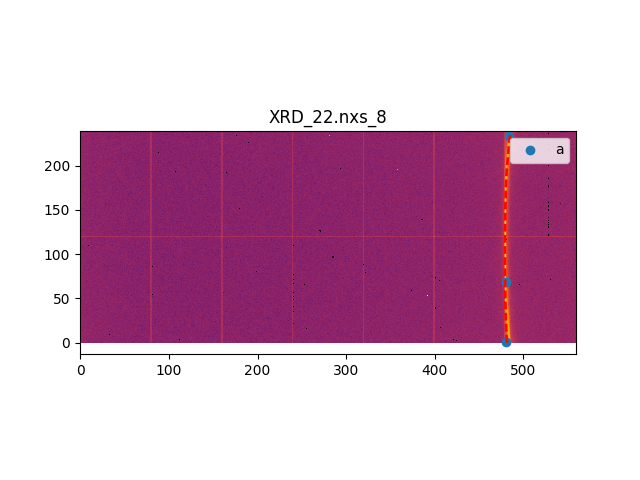

<IPython.core.display.Javascript object>


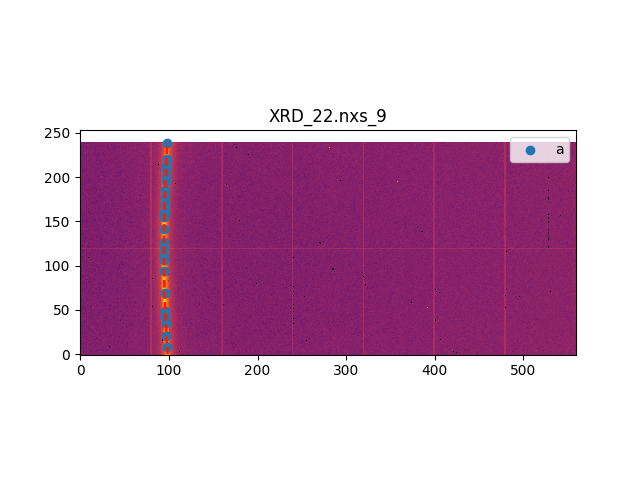

Cost function before refinement: 7.60127961726e-07
[  6.44000000e-01   1.56391117e-02   2.62627647e-02  -1.00000000e+00
  -1.59995037e+01   0.00000000e+00   0.00000000e+00]
     fun: 9.7075132800295773e-09
     jac: array([  1.74816444e-08,  -7.02998659e-09,  -1.58305520e-08,
         1.07238475e-08,   2.42714271e-09,  -1.17950234e-08,
        -5.06261699e-14,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 190
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([  6.43250811e-01,   1.53799594e-02,   2.67720079e-02,
        -9.96015237e-01,  -1.59995107e+01,  -1.60203262e-04,
         0.00000000e+00])
Cost function after refinement: 9.70751328003e-09
GonioParam(dist=0.64325081132243511, poni1=0.01537995935375245, poni2=0.026772007891551666, rot1_scale=-0.99601523685475812, rot1_offset=-15.999510680441723, rot2=-0.00016020326197361458, rot3=0.0)
maxdelta on: rot1_scale (3) -1 --> -0.996015236855

XRD_22.nxs_0
ControlPoints instance contain

<IPython.core.display.Javascript object>


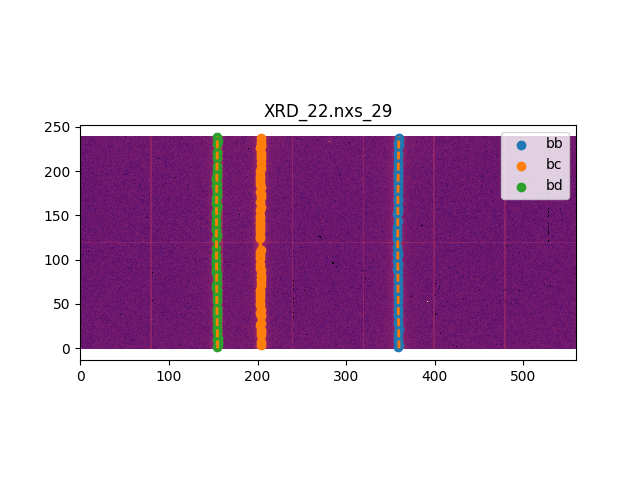

<IPython.core.display.Javascript object>


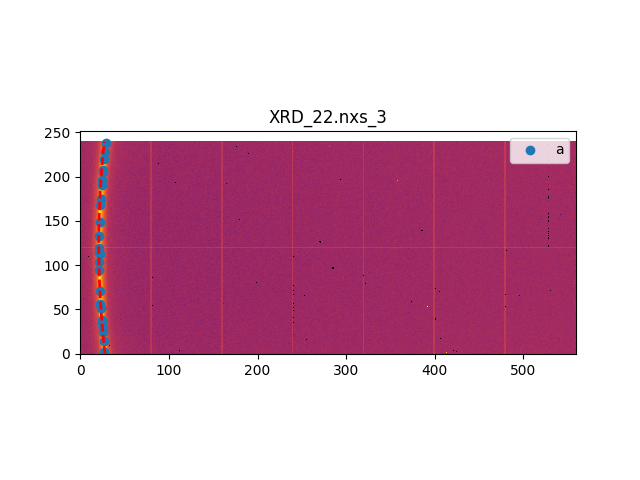

<IPython.core.display.Javascript object>


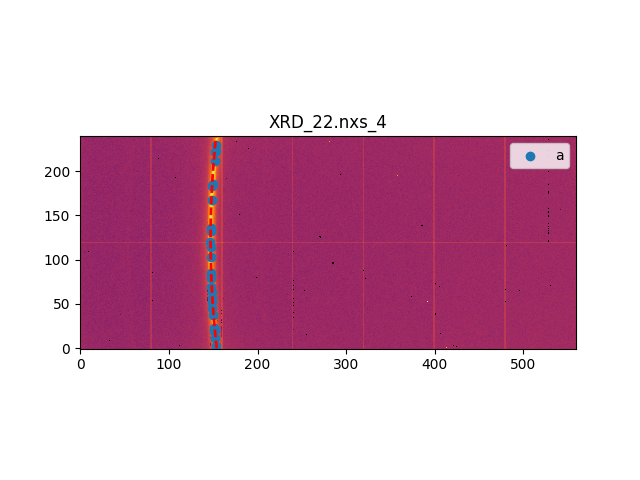

<IPython.core.display.Javascript object>


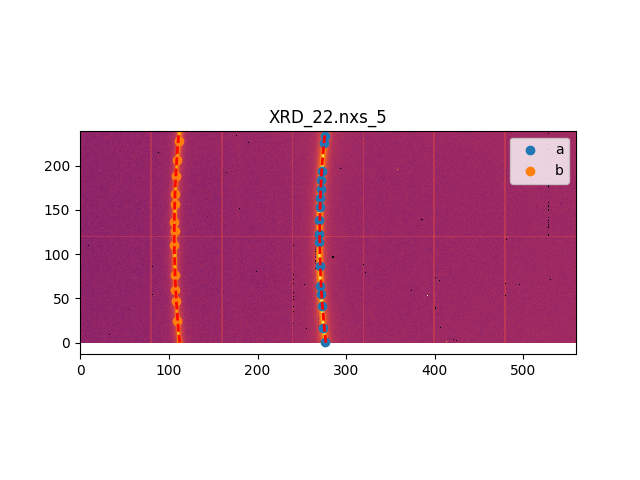

<IPython.core.display.Javascript object>


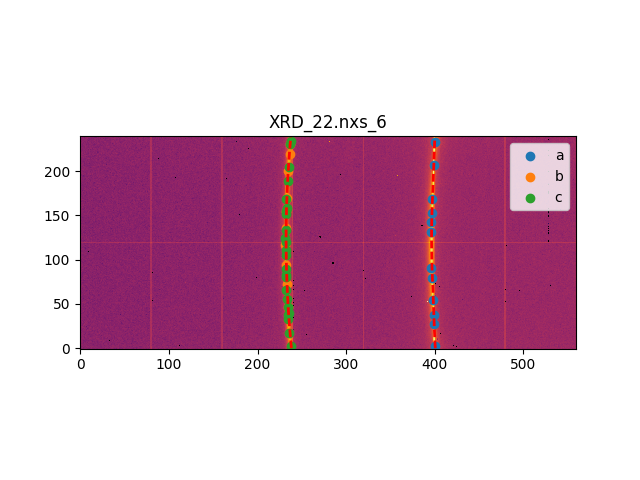

<IPython.core.display.Javascript object>


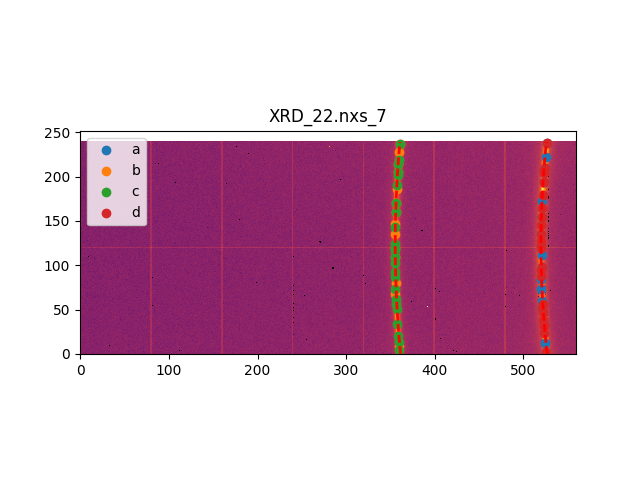

<IPython.core.display.Javascript object>


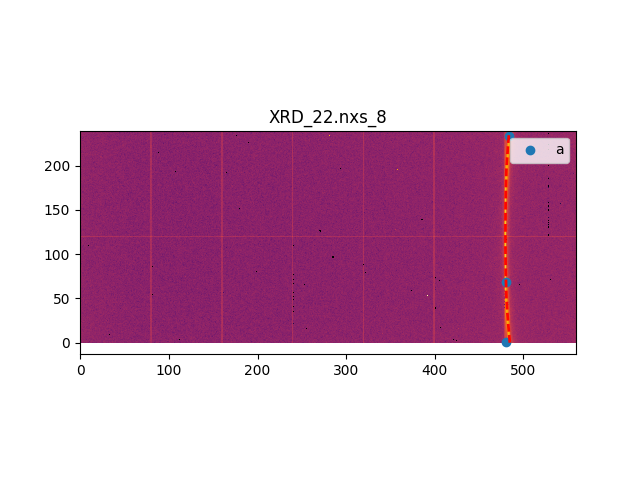

<IPython.core.display.Javascript object>


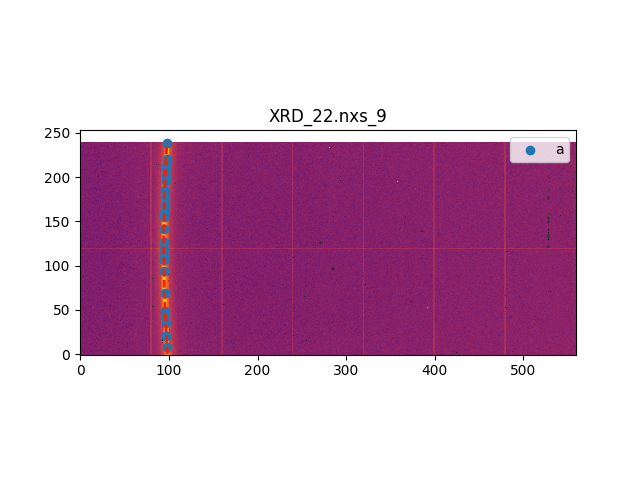

<IPython.core.display.Javascript object>


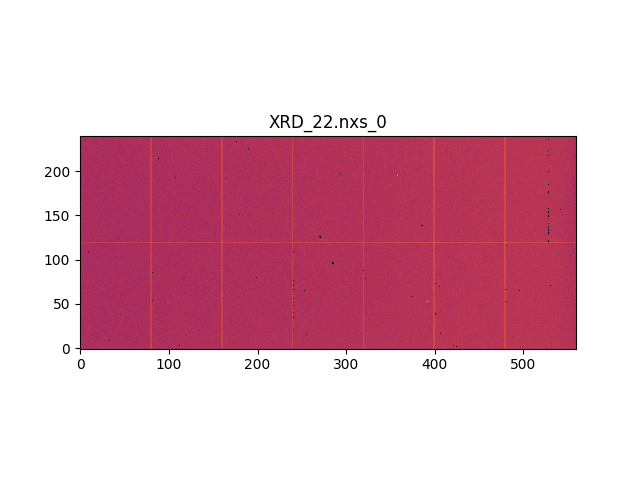

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


<IPython.core.display.Javascript object>


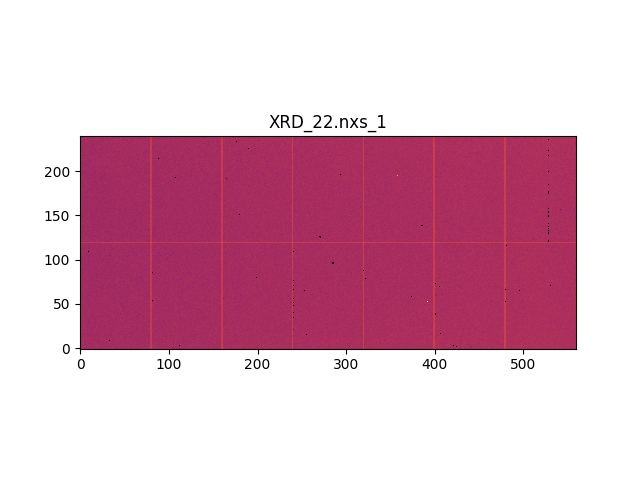

<IPython.core.display.Javascript object>


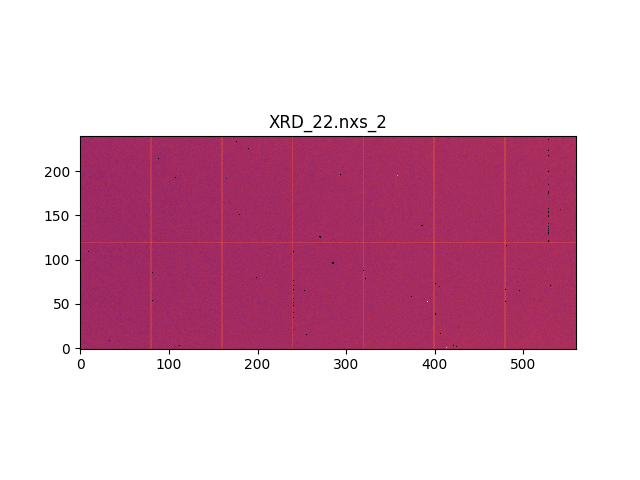

<IPython.core.display.Javascript object>


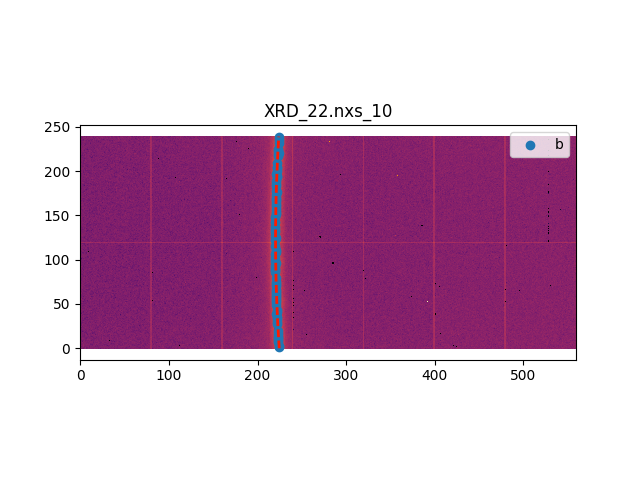

<IPython.core.display.Javascript object>


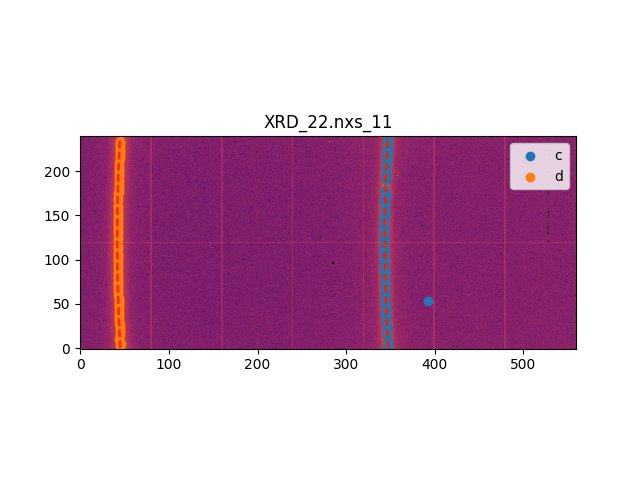

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


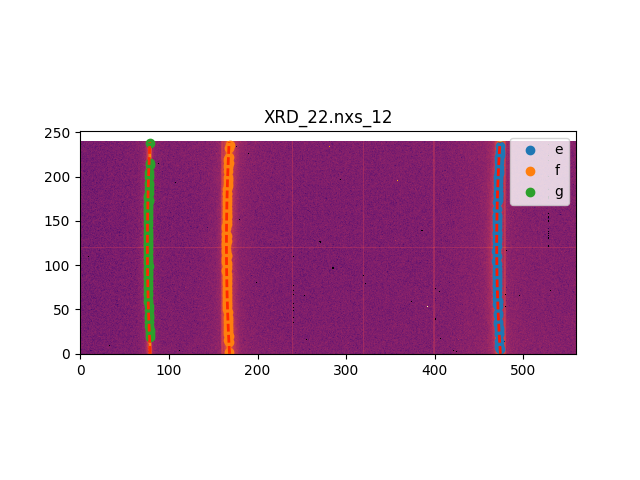

<IPython.core.display.Javascript object>


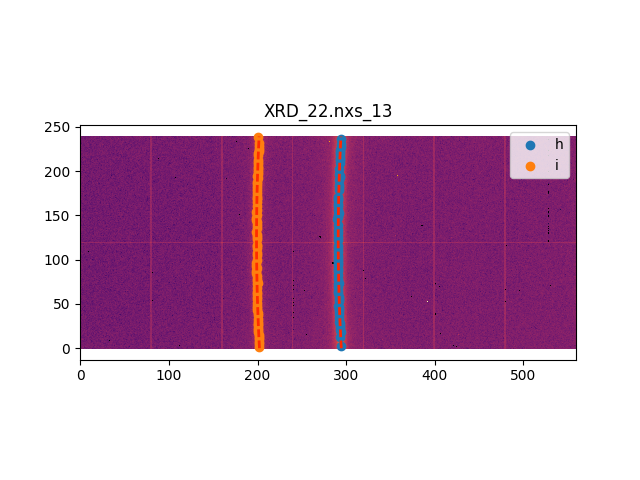

<IPython.core.display.Javascript object>


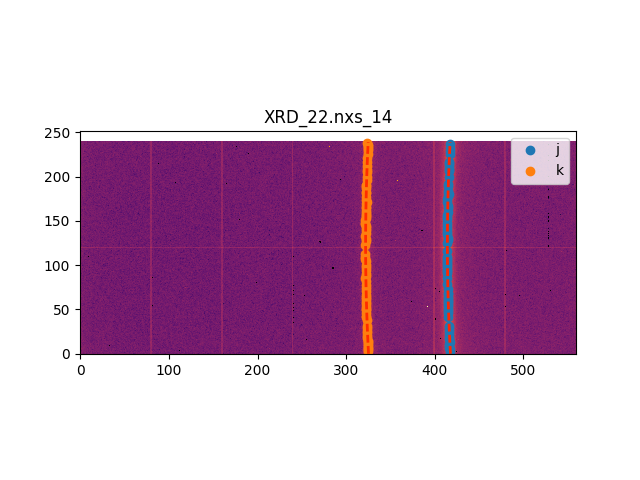

<IPython.core.display.Javascript object>


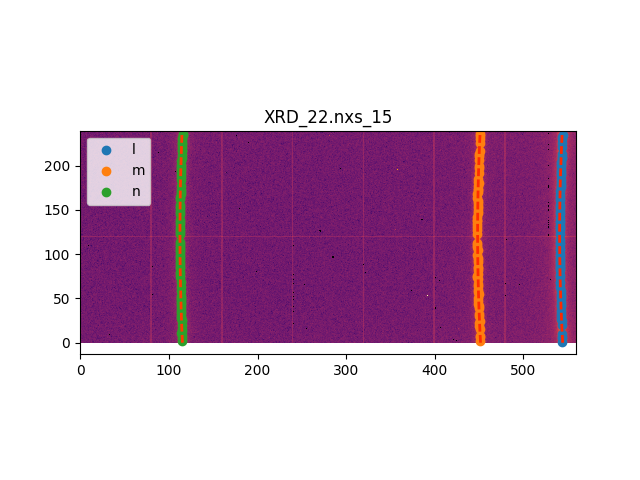

<IPython.core.display.Javascript object>


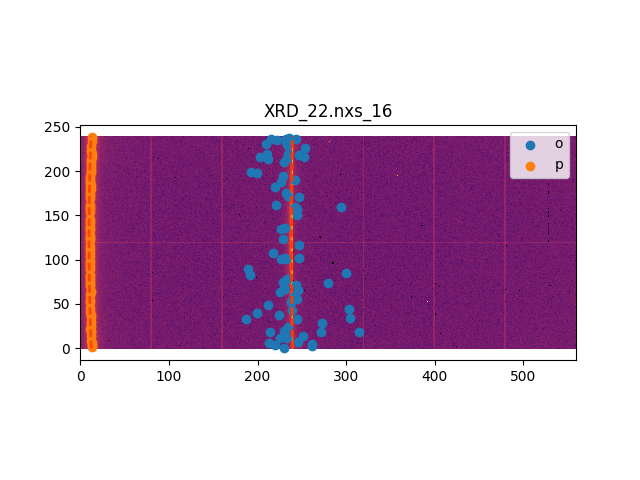

<IPython.core.display.Javascript object>


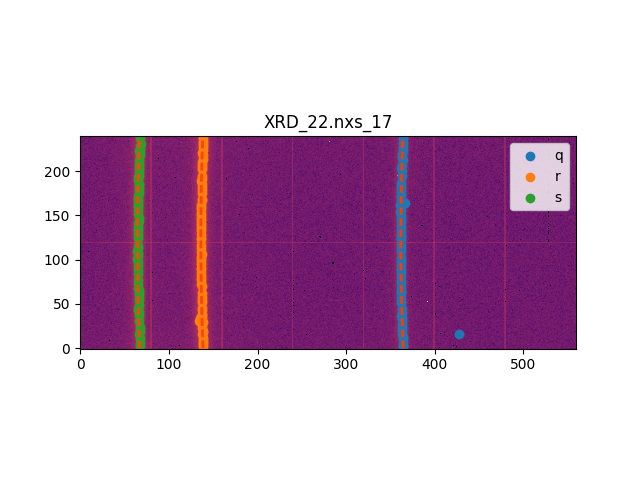

<IPython.core.display.Javascript object>


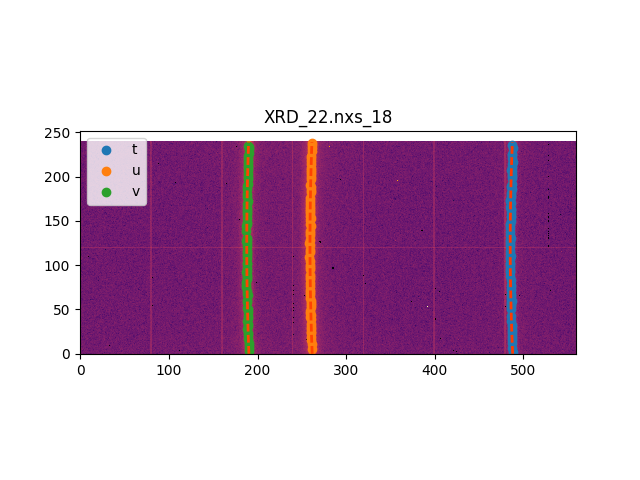

<IPython.core.display.Javascript object>


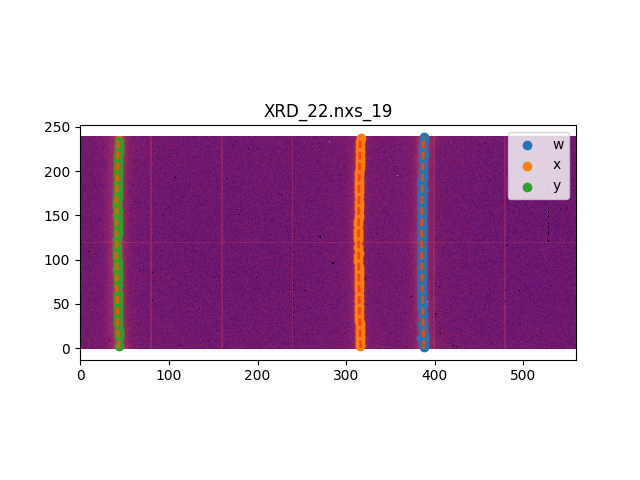

<IPython.core.display.Javascript object>


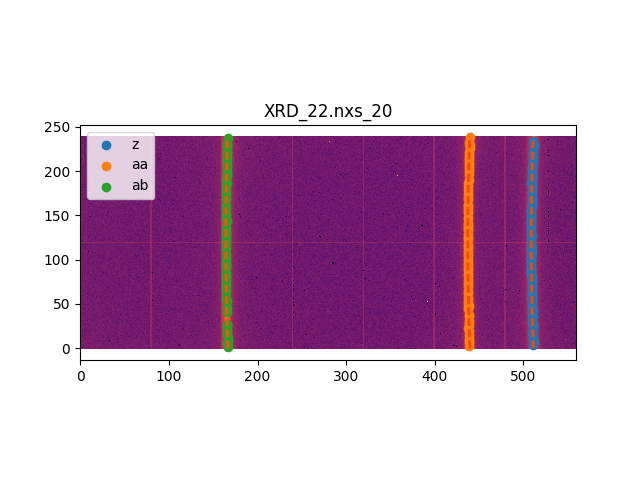

<IPython.core.display.Javascript object>


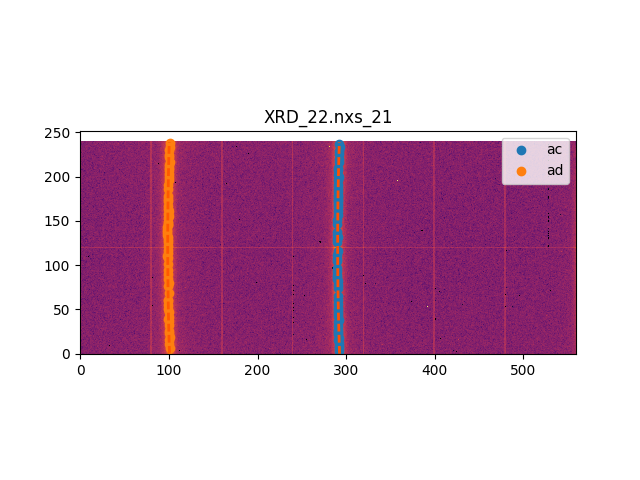

<IPython.core.display.Javascript object>


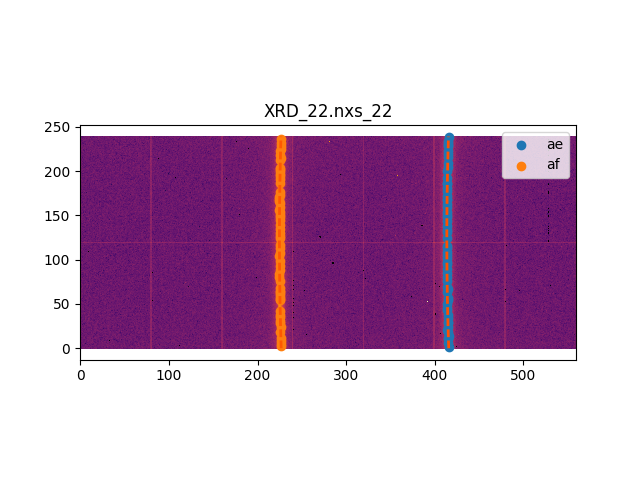

<IPython.core.display.Javascript object>


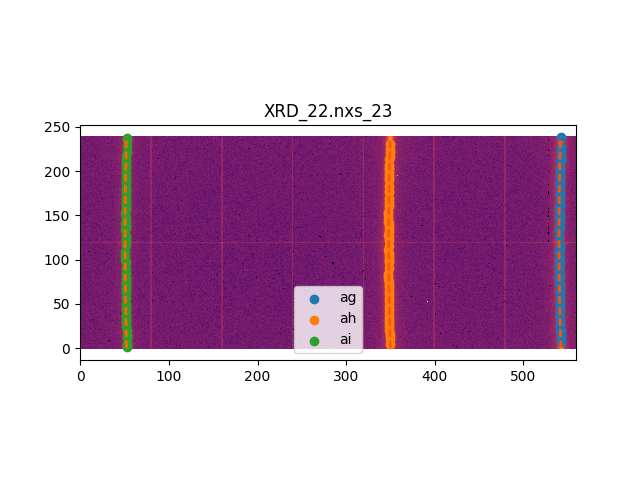

<IPython.core.display.Javascript object>


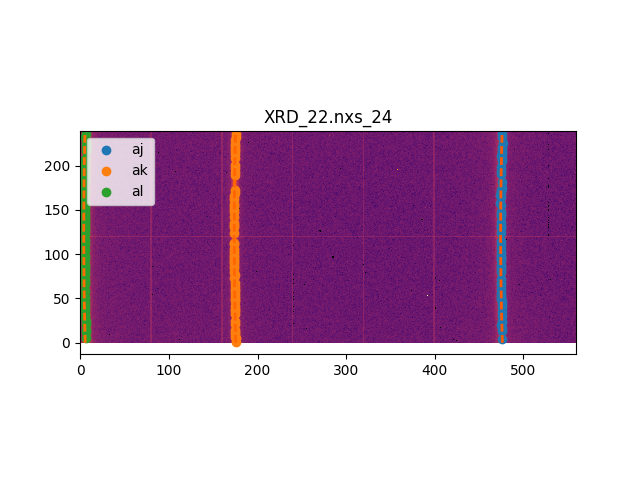

<IPython.core.display.Javascript object>


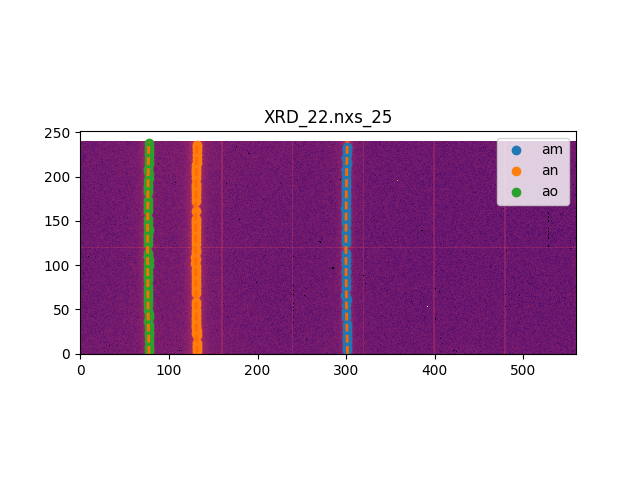

<IPython.core.display.Javascript object>


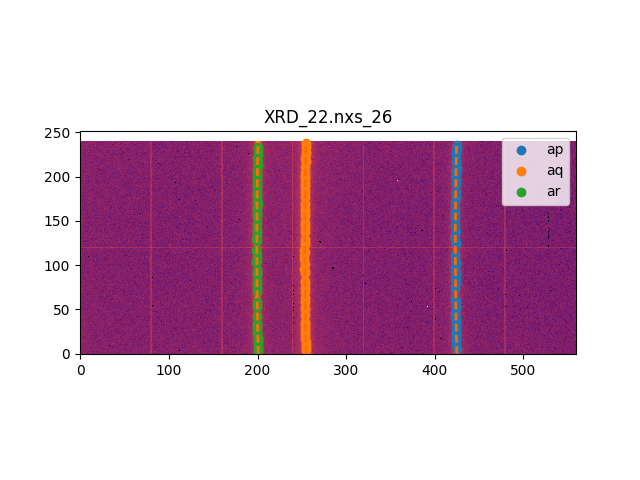

<IPython.core.display.Javascript object>


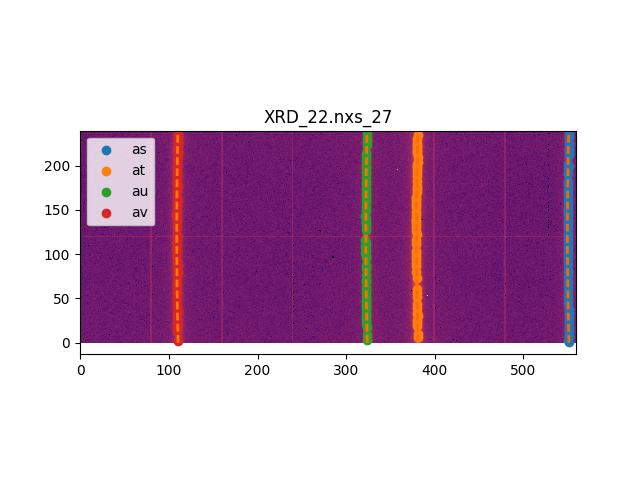

<IPython.core.display.Javascript object>


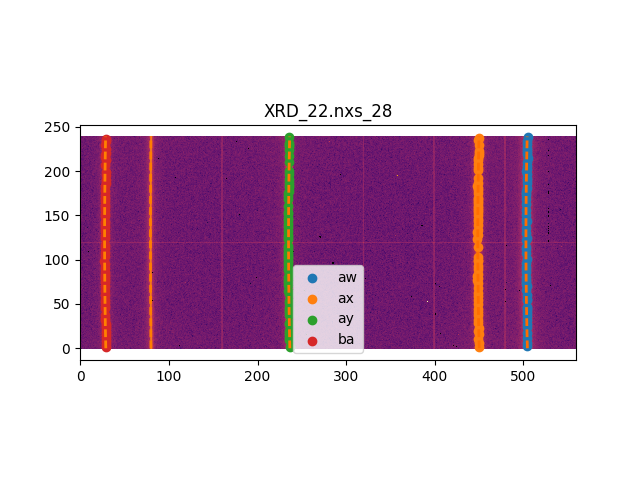

<IPython.core.display.Javascript object>


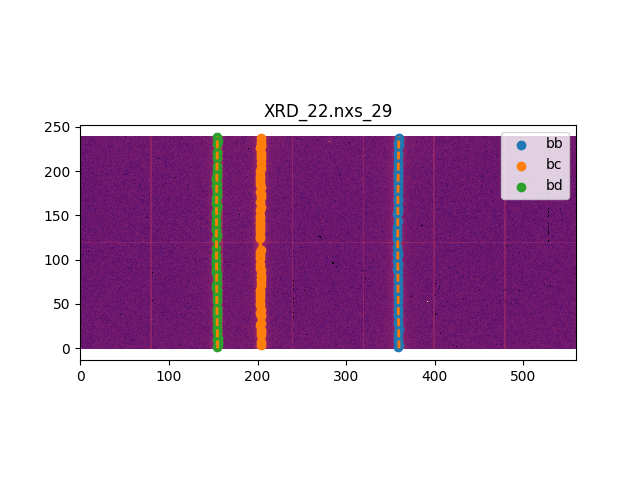

In [7]:
# execute the calibration

calibration(json, params)

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


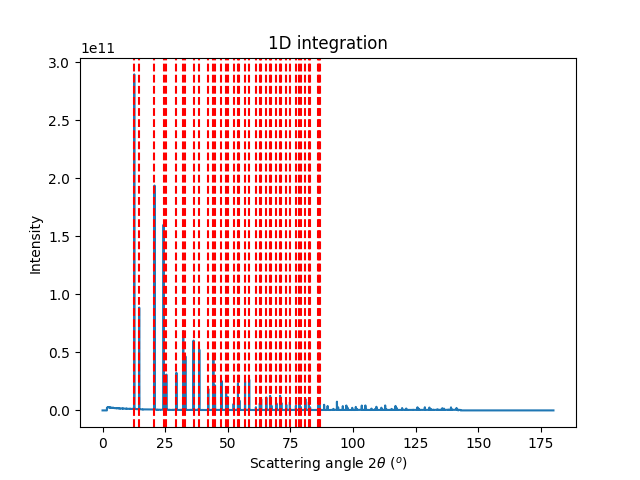

(array([  1.80000021e-03,   5.40000021e-03,   9.00000021e-03, ...,
          1.79991000e+02,   1.79994600e+02,   1.79998200e+02]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

In [8]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate(json, params, f, plot_calibrant=True, n=50000)

## Dark  <a name="dark"></a>

In [9]:
# Compute the mask and the dark
# 3.5 could be simplify with 3.6
# TODO
# - boutons pour visualiser les mask
# - trouver en plus du mask standard, les pixels bizards.
#   - qui ne comptent pas.
#   - afficher une images des ecarts types spatiaux + temporels.

DarkMaskSources = NamedTuple('DarkMaskSources', [('filenames', List[Text]),  # name of the files
                                                 ('threshold', int),  # mask all pixel above this treshold
                                                 ('detector', Optional[Text]),
                                                 ('images_path', DatasetPath)])

darkMaskSources = DarkMaskSources([os.path.join(COM_DIFFABS, "2018", "Run3", "2018-05-17", "scan_21.nxs")],
                                  1, 'imxpad_s140',
                                  DatasetPathWithAttribute("interpretation", b"image"))

In [10]:
# display all the dark & mask images

for filename in darkMaskSources.filenames:
    my_cmd_button("silx view --use-opengl-plot " + filename,
                  'Silx View ' + os.path.basename(filename))

DescribeResult(nobs=27014400, minmax=(0.0, 1745482.0), mean=20.179383884150674, variance=25639788.549425509, skewness=290.94567921018034, kurtosis=87548.66625755277)
images (median):  0.0
DescribeResult(nobs=134400, minmax=(0.0, 1506813.616915423), mean=20.179383884150678, variance=22916001.015130356, skewness=275.8958203483435, kurtosis=80710.26790327836)
dark (median):  0.0


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


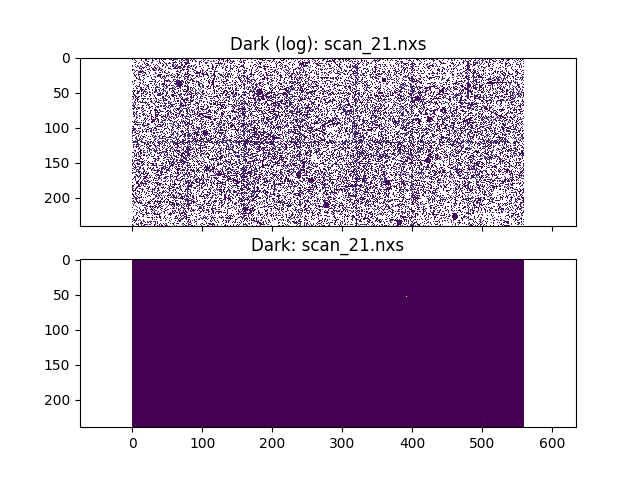

/usr/lib/python3/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


In [11]:
#definition du dark à partir du fichier acquis

def make_dark(params: DarkMaskSources) -> ndarray:
    for filename in params.filenames: 
        with File(filename, mode='r') as f:
            images = get_dataset(f, params.images_path)[:].astype("double")
            print(scipy.stats.describe(images, axis=None))
            print("images (median): ", numpy.median(images))
            dark = images.mean(axis=0)
            print(scipy.stats.describe(dark, axis=None))
            print("dark (median): ", numpy.median(dark))


            fig, ax = pylab.subplots(2, 1, sharex=True, sharey=True)
            ax0 = ax[0]
            ax0.imshow(numpy.log(dark))
            ax0.set_title("Dark (log): " + os.path.basename(params.filenames[0]))
            ax1 = ax[1]
            ax1.imshow(dark)
            ax1.set_title("Dark: " + os.path.basename(params.filenames[0]))

            return dark
            
dark= make_dark(darkMaskSources)

## Flat  <a name="flat"></a>

DescribeResult(nobs=2822400, minmax=(0.0, 64793.0), mean=13.917953869047619, variance=29877.180567957825, skewness=265.98231402511703, kurtosis=75631.99866670113)
images (median):  13.0
DescribeResult(nobs=134400, minmax=(0.0, 37294.047619047618), mean=13.917953869047619, variance=23781.393332603711, skewness=214.7391903290596, kurtosis=46841.602452227366)
flat (median):  12.7142857143


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


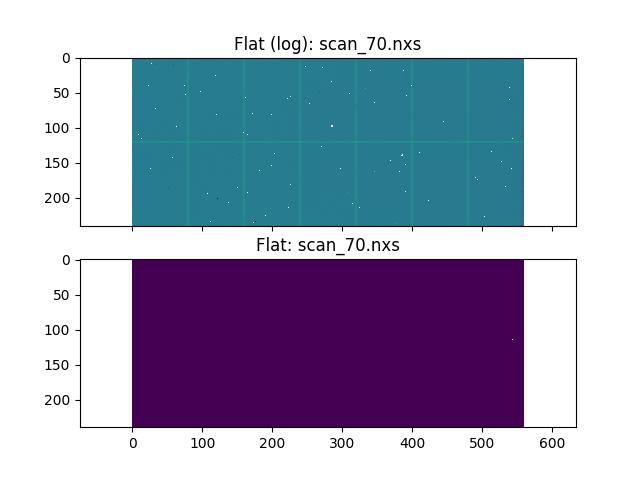

flat time:  0.47308850288391113


/usr/lib/python3/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in log


In [12]:
# compute the flat

FlatParams = NamedTuple('FlatParams', [('filename', Text),  # name of the file
                                       ('dark', Optional[ndarray]),
                                       ('images_path', DatasetPath)])

def get_flat(params: FlatParams) -> ndarray:
    """
    :param filename: name of the files
    :type filename: list(str)

    génère un flat corrigé du dark si dark is not None
    """
    with File(params.filename, mode='r') as f:
        images = get_dataset(f, params.images_path)[:].astype("double")
        print(scipy.stats.describe(images, axis=None))
        print("images (median): ", numpy.median(images))
        flat = images.mean(axis=0)
        print(scipy.stats.describe(flat, axis=None))
        print("flat (median): ", numpy.median(flat))
        if dark is not None:
            flat -= dark

        return flat

t0 = time.time()
flatParams =  FlatParams(os.path.join(ROOT_FLAT, "2017", "Run5", "2017-11-15", "scan_70.nxs"),
                         None, # dark,
                         DatasetPathWithAttribute("interpretation", b"image"))
flat = get_flat(flatParams)

fig, ax = pylab.subplots(2, 1, sharex=True, sharey=True)
ax0 = ax[0]
ax0.imshow(numpy.log(flat))
ax0.set_title("Flat (log): " + os.path.basename(flatParams.filename))
ax1 = ax[1]
ax1.imshow(flat, vmin=0)
ax1.set_title("Flat: " + os.path.basename(flatParams.filename))


print("flat time: ", time.time() - t0)

In [13]:
# Add a button in order to explore the flat file

silx_flat = my_cmd_button("silx view --use-opengl-plot " + flatParams.filename,
                          'Silx View ' + os.path.basename(flatParams.filename))

## Mask  <a name="mask"></a>

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


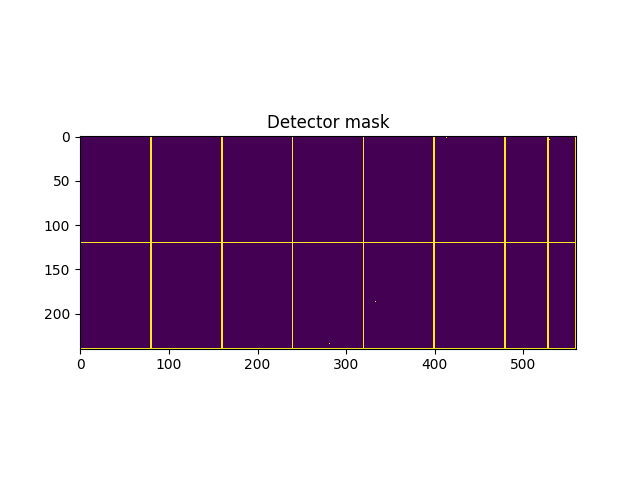

<IPython.core.display.Javascript object>


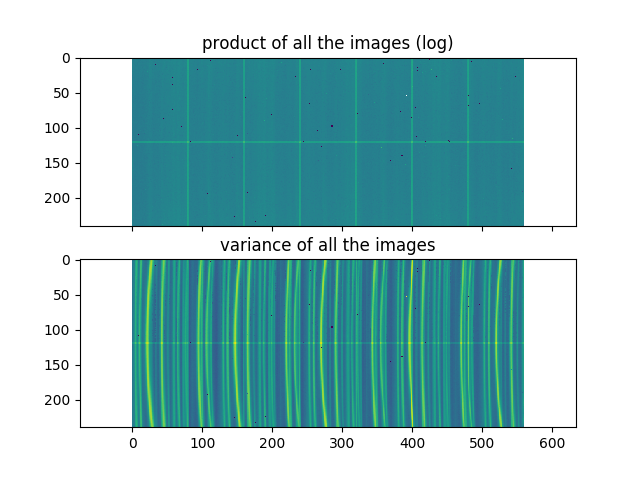

<IPython.core.display.Javascript object>


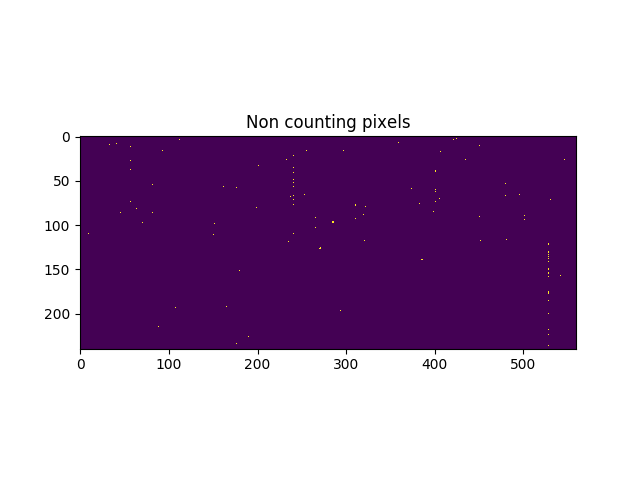

<IPython.core.display.Javascript object>


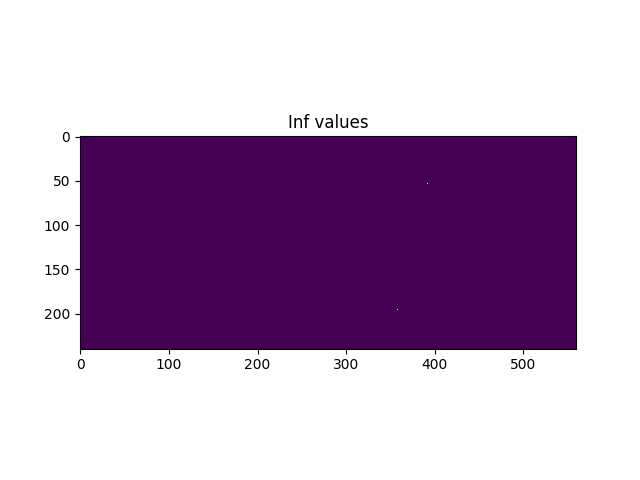

<IPython.core.display.Javascript object>


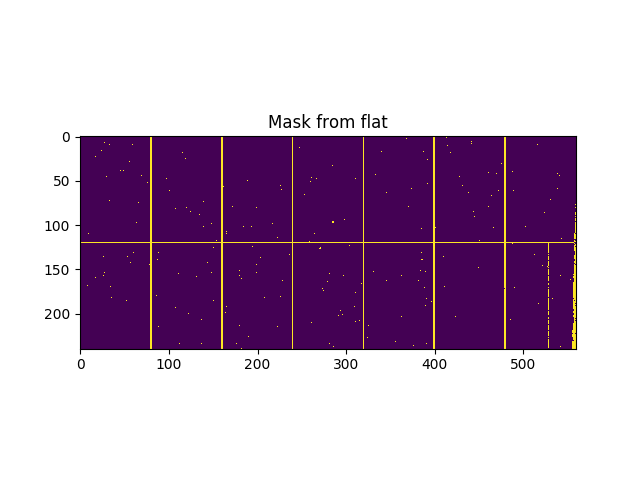

<IPython.core.display.Javascript object>


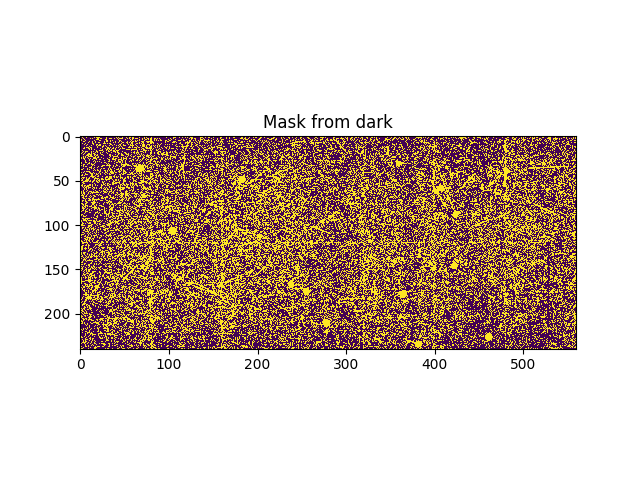

<IPython.core.display.Javascript object>


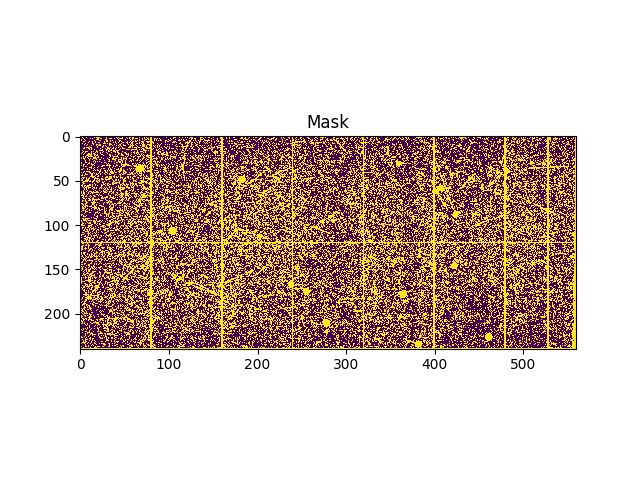

In [14]:
# create a bunch of function used to generate the mask

def mask_from_detector(detector: str) -> numpy.ndarray:
        det = detector_factory(detector)
        mask = det.calc_mask() ## int8
        
        # on a repere des discidents
        mask[:, 527:529] = 1
        mask[1, 413] = 1
        mask[3, 530] = 1
        mask[186, 333] = 1
        mask[233, 281] = 1
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask)
        ax.set_title("Detector mask")

        return mask
    
def mask_from_data(params: Calibration) -> numpy.ndarray:
    prod_threshold = 1
    always_threshold = 660
    
    with File(params.filename, mode='r') as h5file:
        images = get_dataset(h5file, params.images_path)[:].astype('double')
        
        # product and variance of all the images
        prod = images.prod(axis=0)
        var = images.var(axis=0)
        fig, ax = pylab.subplots(2, 1, sharex=True, sharey=True)
        ax0 = ax[0]
        ax0.set_title('product of all the images (log)')
        ax0.imshow(numpy.log(prod+1.0))
        ax1 = ax[1]
        ax1.set_title('variance of all the images')
        ax1.imshow(numpy.log(var+1.0))

        # remove the non counting pixels
        mask_non_counting = numpy.where(prod < prod_threshold, 1, 0).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_non_counting)
        ax.set_title("Non counting pixels")
        
        # remove the inf values
        mask_inf = numpy.isinf(prod).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_inf)
        ax.set_title("Inf values")

        mask = mask_non_counting.copy()
        mask = numpy.logical_or(mask, mask_inf)
        
        return mask

def mask_from_flat(detector: str,
                   flat: Optional[ndarray]):
    det = detector_factory(detector)
    if flat is None:
        mask = numpy.zeros_like(det.calc_mask(), dtype='int8')
    else:
        # TODO check that the detector and the flat dimension are compatible.
        mask = numpy.where(flat < 6, 1, 0).astype('int8')
        mask = numpy.logical_or(mask, numpy.where(flat > 20, 1, 0))

    fig, ax = pylab.subplots(1, 1)
    ax.imshow(mask)
    ax.set_title("Mask from flat")
        
    return mask

def mask_from_dark(detector: str,
                   dark: Optional[ndarray]):
    det = detector_factory(detector)
    if flat is None:
        mask = numpy.zeros_like(det.calc_mask(), dtype='int8')
    else:
        # TODO check that the detector and the flat dimension are compatible.
        mask = numpy.where(dark != 0, 1, 0).astype('int8')

    fig, ax = pylab.subplots(1, 1)
    ax.imshow(mask)
    ax.set_title("Mask from dark")
        
    return mask

mask = mask_from_detector(params.detector)
mask = numpy.logical_or(mask, mask_from_data(params))
mask = numpy.logical_or(mask, mask_from_flat(params.detector, flat))
mask = numpy.logical_or(mask, mask_from_dark(params.detector, dark))

fig, ax = pylab.subplots(1, 1, sharex=True, sharey=True)
ax.imshow(mask)
ax.set_title('Mask')

## Integration <a name="integration"></a>

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_22.nxs


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


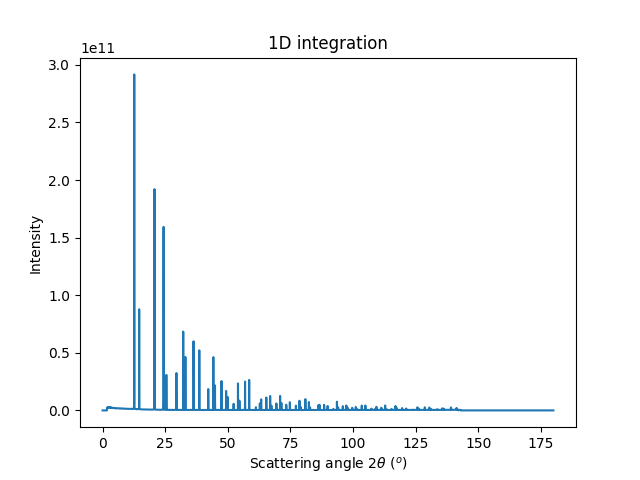

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_29.nxs


<IPython.core.display.Javascript object>


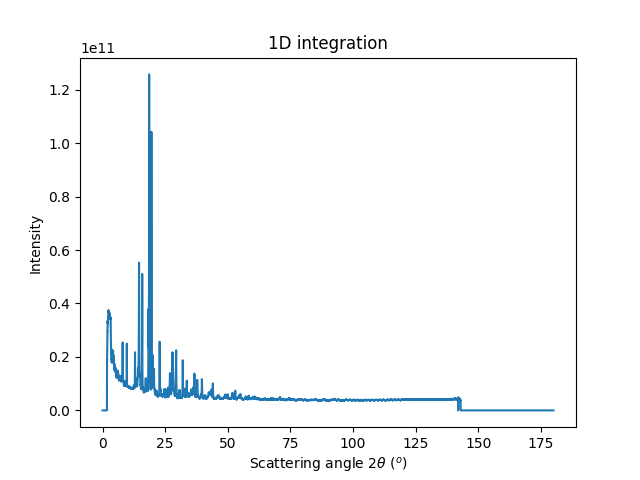

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_32.nxs


<IPython.core.display.Javascript object>


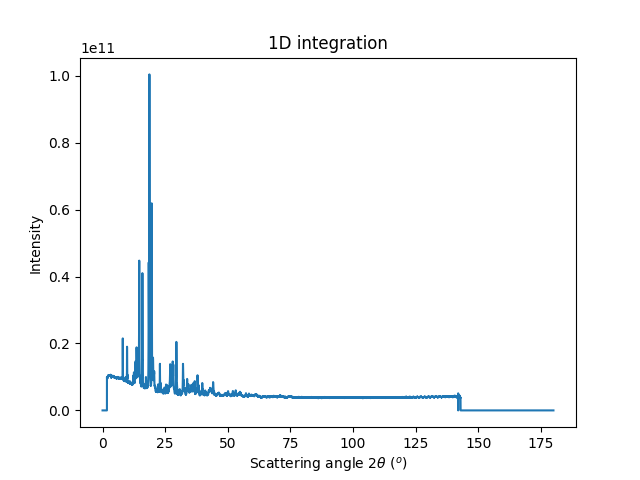

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_38.nxs


<IPython.core.display.Javascript object>


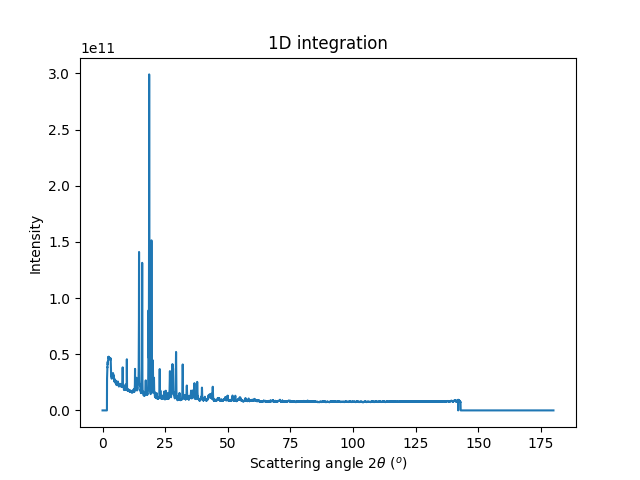

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_45.nxs


<IPython.core.display.Javascript object>


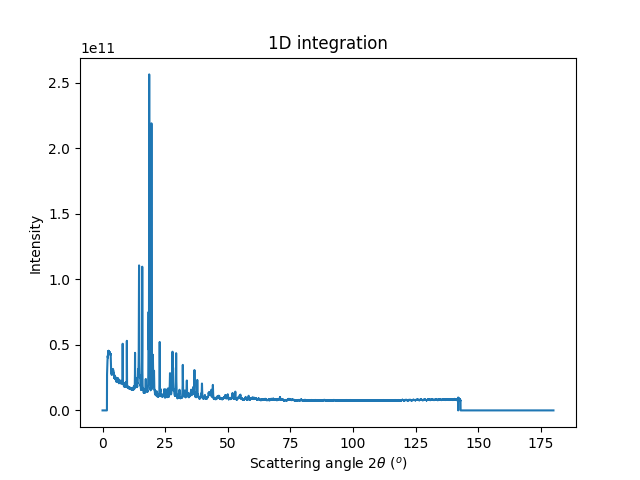

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_49.nxs


<IPython.core.display.Javascript object>


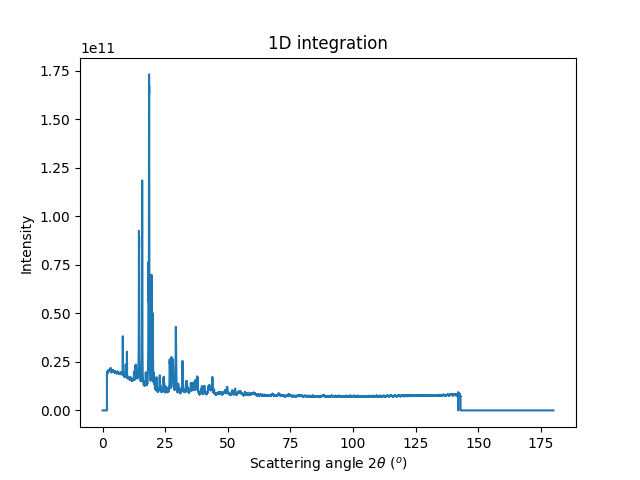

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_54.nxs


<IPython.core.display.Javascript object>


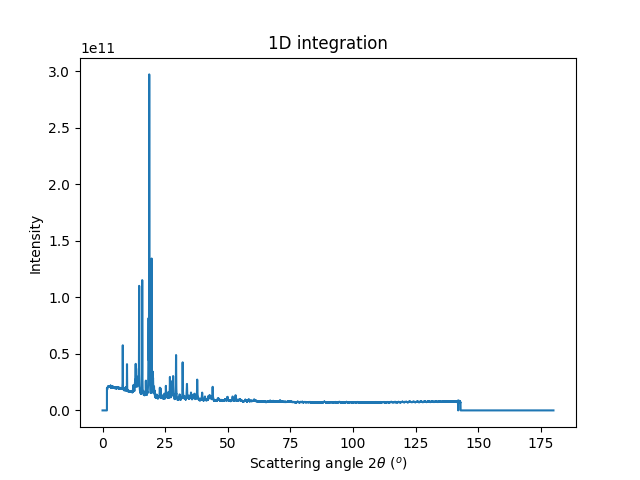

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_58.nxs


<IPython.core.display.Javascript object>


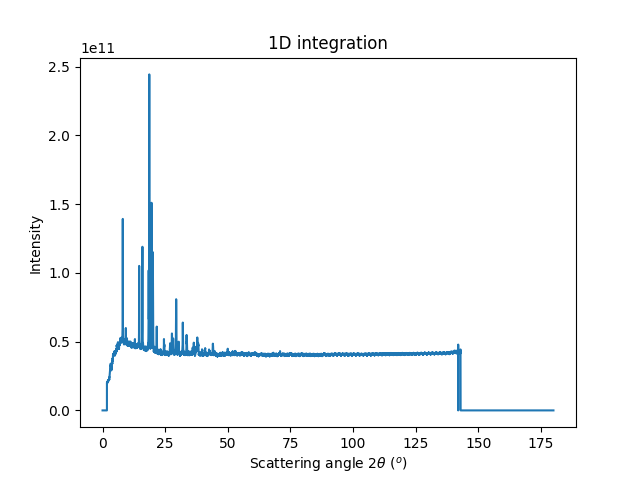

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_62.nxs


<IPython.core.display.Javascript object>


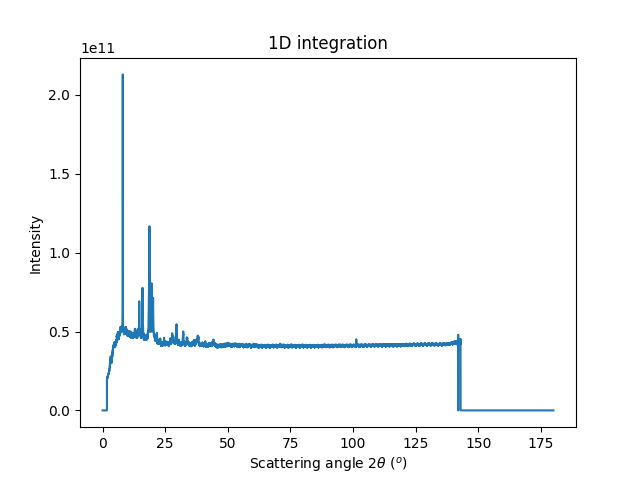

/nfs/ruche-diffabs/diffabs-users/20170882/2018/Run2/2018-04-03/XRD_69.nxs


<IPython.core.display.Javascript object>


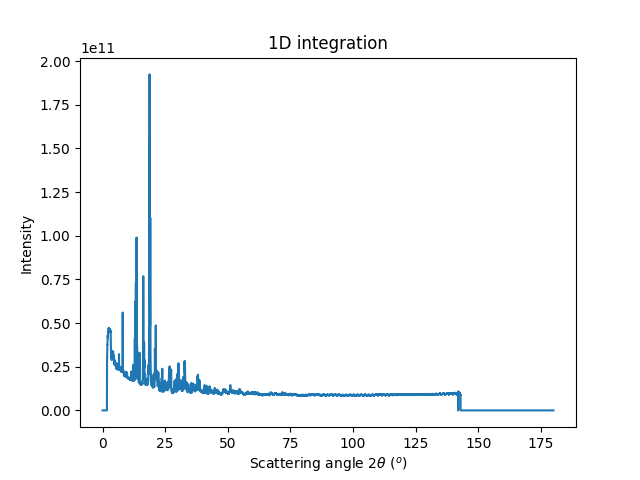

In [17]:
# integrate all the diffractogram

# let's take all the images
def to_use_sample(frame: CalibrationFrame) -> bool:
    return True


def mkCalibration(i: int) -> Calibration:
    return Calibration(os.path.join(PUBLISHED, "xrd", "calibration"),
                       os.path.join(ROOT, "2018-04-03", "XRD_{:d}.nxs".format(i)),
                       DatasetPathWithAttribute("interpretation", b"image"),
                       DatasetPathContains("scan_data/actuator_1_1"),
                       [1],
                       to_use_sample,
                       Calibrant("CeO2"),
                       Detector("xpad_flat"),
                       Wavelength(6.8877e-11),
                       functions
                       )

CeO2 = [mkCalibration(i) for i in [22]]
Sm2MnNi = [mkCalibration(i) for i in [29, 32, 38, 45, 49, 54]]
Y2MnNi = [mkCalibration(i) for i in [58, 62]]
AB12 = [mkCalibration(i) for i in [69]]
#Sm2MnNi = [mkCalibration(i) for i in range(29, 248)]

def f(img: ndarray) -> ndarray:
    #img = numpy.where(img > 14000, 0, img).astype('double')
    return img

samples = CeO2 + Sm2MnNi + Y2MnNi + AB12
#samples = CeO2
#samples = Y2MnNi

for s in samples:
    print(s.filename)
    res1 = integrate(json, s, f, save=True, n=50000, lst_mask=mask)
    #res2 = integrate(json, s, f, save=False, n=50000, lst_mask=mask, lst_flat=flat)
    my_cmd_button("silx view --use-opengl-plot " + s.filename,
                  'Silx View ' + os.path.basename(s.filename))

In [16]:
#fig, ax = pylab.subplots(2, 1, sharex=True, sharey=True)
#ax0 = ax[0]
#ax0.plot(res1[0], numpy.log(res1[1] / res1[1].max()))
#ax0.set_title("without flat correction")

#ax1 = ax[1]
#ax1.plot(res2[0], numpy.log(res2[1] / res2[1].max()))
#ax1.set_title("with flat correction")